In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from copulas.multivariate import GaussianMultivariate
from scipy import stats

In [2]:
data_nm="indexProcessed.csv"
base_data_folder="data"

In [3]:
data_path=os.path.join("..",base_data_folder,data_nm)
if not os.path.isfile(data_path):
    print("Downloading data ...")
    !kaggle datasets download -d mattiuzc/stock-exchange-data -p ../data --unzip
    print("Download done!")
else:
    print("Data already exist")

 66%|█████████████████████████             | 3.00M/4.56M [00:00<00:00, 4.83MB/s]
100%|██████████████████████████████████████| 4.56M/4.56M [00:00<00:00, 5.45MB/s]
Download done!


In [4]:
df=pd.read_csv(data_path)
df.head(5)

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013


In [5]:
df.Index.unique()

array(['HSI', 'NYA', 'IXIC', '000001.SS', 'N225', 'N100', '399001.SZ',
       'GSPTSE', 'NSEI', 'GDAXI', 'SSMI', 'TWII', 'J203.JO'], dtype=object)

In [ ]:
def filter_df(df):
    df_hsi=df.query("Index =='HSI'").reset_index(drop=True)
    df["pct_change"]=df_hsi.Close.pct_change()
    df["year"]=df_hsi["Date"].apply(lambda x: x[0:4]).astype(int)
    return df.query("year>2010").reset_index(drop=True)

In [41]:
df_hsi=df.query("Index =='HSI'").reset_index(drop=True)
df_hsi["pct_change"]=df_hsi.Close.pct_change()
df_hsi["year"]=df_hsi["Date"].apply(lambda x: x[0:4]).astype(int)
df_hsi=df_hsi.query("year>2010")
df_hsi['pct_change'] = df.Close.pct_change()
df_hsi['log_return'] = np.log(1 + df_hsi["pct_change"])
data=df_hsi['log_return']


In [36]:
df_hsi['pct_change'] = df.Close.pct_change()
df_hsi['log_return'] = np.log(1 + df_hsi["pct_change"])
data=df_hsi['log_return']

In [40]:
df_hsi

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD,pct_change,year,log_return
5934,HSI,2011-01-03,23135.64063,23443.52930,23057.51953,23436.05078,23436.05078,1.066930e+09,3046.686601,0.018988,2011,0.018810
5935,HSI,2011-01-04,23477.31055,23695.60938,23408.08984,23668.48047,23668.48047,1.330693e+09,3076.902461,0.009918,2011,0.009869
5936,HSI,2011-01-05,23650.17969,23773.98047,23579.74023,23757.82031,23757.82031,1.277768e+09,3088.516640,0.003775,2011,0.003768
5937,HSI,2011-01-06,23861.22070,23861.22070,23698.38086,23786.30078,23786.30078,1.147689e+09,3092.219101,0.001199,2011,0.001198
5938,HSI,2011-01-07,23744.02930,23880.76953,23654.03906,23686.63086,23686.63086,1.287346e+09,3079.262012,-0.004190,2011,-0.004199
...,...,...,...,...,...,...,...,...,...,...,...,...
8487,HSI,2021-05-25,28461.50000,28929.24023,28461.50000,28910.85938,28910.85938,2.352078e+09,3758.411719,0.017549,2021,0.017397
8488,HSI,2021-05-26,29056.27930,29261.85938,29027.94922,29166.00977,29166.00977,2.518538e+09,3791.581270,0.008825,2021,0.008787
8489,HSI,2021-05-27,28998.39063,29157.94922,28950.72070,29113.19922,29113.19922,3.804955e+09,3784.715899,-0.001811,2021,-0.001812
8490,HSI,2021-05-28,29219.46094,29336.13086,29033.72070,29124.41016,29124.41016,2.591560e+09,3786.173321,0.000385,2021,0.000385


In [37]:
def test_gaussian(data):
    res = stats.normaltest(data)
    # interpret
    alpha = 0.05
    p=res.pvalue
    print(f"P-Value: {p}")
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [38]:
test_gaussian(data)

P-Value: 1.580002206156981e-44
Sample does not look Gaussian (reject H0)


In [33]:
def create_hist_and_normal_approximation(data):
    ax = sns.histplot(data, kde=True, stat='density', label='samples')
    _mean=data.mean()
    _std=data.std()
    # calculate the pdf
    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = stats.norm.pdf(x_pdf,loc=_mean,scale=_std)
    ax.plot(x_pdf, y_pdf, 'r', lw=2, label='Normal Approximation')                                                   
    ax.legend()
    return None

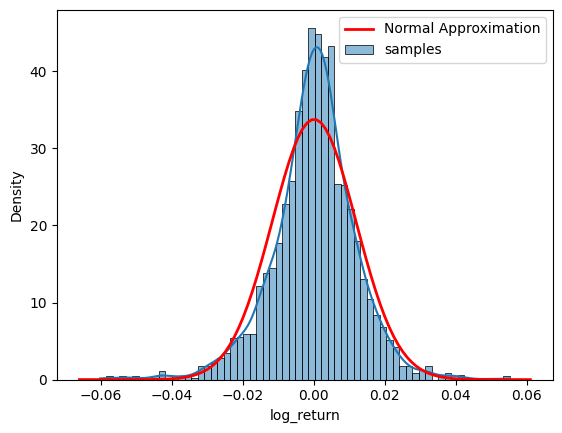

In [39]:
create_hist_and_normal_approximation(data)

In [20]:
df_hsi["pct_change"]

5934    0.018988
5935    0.009918
5936    0.003775
5937    0.001199
5938   -0.004190
          ...   
8487    0.017549
8488    0.008825
8489   -0.001811
8490    0.000385
8491    0.000940
Name: pct_change, Length: 2558, dtype: float64